<a href="https://colab.research.google.com/github/Shruti-T/Lunar-Lander/blob/main/Deep_Q_Learning_for_Lunar_Landing_Partial_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Learning for Lunar Landing

## Part 0 - Installing the required packages and importing the libraries

### Installing Gymnasium

In [1]:
!pip install gymnasium
!pip install "gymnasium[atari, accept-rom-license]"
!apt-get install -y swig
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 15.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 51.9 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=fa811b292277e8cd737dd7ea51b56ad4805c60d17c36af4eb8d16e594dc3dd50
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installe

### Importing the libraries

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
from collections import deque, namedtuple

## Part 1 - Building the AI

### Creating the architecture of the Neural Network

In [3]:
class Network(nn.Module):

  def __init__(self, state_size , action_size, seed=42) :
    super(Network, self).__init__() # super keyword in python is for inheritance
    self.seed= torch.manual_seed(seed) #seed selection at random using inbuilt pytorch funciton - manual_seed
    self.fc1 = nn.Linear(state_size, 64) # look notes for function explanation.
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, action_size)

  # forward function will propogate the inputs form input layer to output layer via hidden layer.
  def forward(self, state):
    x = self.fc1(state) # returns 1st connected layer
    x = F.relu(x) #relu is rectifier activation function from pytorch module
    x = self.fc2(x) # returns 2st connected layer, x variable updated as 2nd layer
    x = F.relu(x)
    return self.fc3(x)


## Part 2 - Training the AI

### Setting up the environment

In [4]:
import gymnasium as gym # had it installed not imported before hence the step
env = gym.make('LunarLander-v2') # from gymnasium documentation.... steps to import
state_shape = env.observation_space.shape # form
state_size = env.observation_space.shape[0]
number_actions = env.action_space.n
print('State shape: ', state_shape)
print('State size: ', state_size)
print('Number of acitons: ', number_actions)


State shape:  (8,)
State size:  8
Number of acitons:  4


### Initializing the hyperparameters

In [5]:
learning_rate = 5e-4 # check in detail about all these hyperparameter and what they offer in AI
minibatch_size = 100
discount_factor = 0.99
replay_buffer_size = int(1e5)
interpolation_parameter = 1e-3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Implementing Experience Replay

In [6]:
class ReplayMemory(object): #new class no inheritance
  # constructive method to initialize the replay memory method
  def __init__(self,capacity): # capacity of memory
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # if we want to use the code outside of colab...  eg incase jupiter..
    self.capacity = capacity
    self.memory = [] # list that stores the experience i.e state, action, reward, we done or not..

  # push method to add an experience event into the memory buffer
  def push(self, event): # event has all those state, action, reward... etc
    self.memory.append(event)
    # for this to not exceed its capacity
    if len(self.memory) > self.capacity:
      del self.memory[0]

  # sample method to randomly select batch of experience form memory buffer
  def sample(self, batch_size): # number of experiences that are gonna be sampled in the batch
    experiences = random.sample(self.memory, k = batch_size)
    #To extract one by one each different element of each sample (state, action, reward)
    states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None ])).float().to(self.device) # check diary for explanation
    actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None ])).long().to(self.device)
    rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None ])).float().to(self.device)
    next_states= torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None ])).float().to(self.device)
    dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None ]).astype(np.uint8)).float().to(self.device)
    return states, next_states, actions, rewards, dones


### Implementing the DQN class

In [7]:
class Agent():
  def __init__(self, state_size, action_size):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.state_size = state_size
    self.action_size = action_size
    # creating two network i.e instance of class Network.
    self.local_qnetwork = Network(state_size, action_size).to(self.device)
    self.target_qnetwork = Network(state_size, action_size).to(self.device)
    # optimizer which is being created form adam class.... from optim module.
    self.optimizer = optim.Adam(self.local_qnetwork.parameters(),lr = learning_rate)
    # memory of AI instance using memory class, takes argument as capacity=replay buffer size
    self.memory = ReplayMemory(replay_buffer_size)
    #time stamp i.e at which moment we learn and update the ntw params
    self.t_step = 0

  def step(self, state, action, reward, next_state, done):
    # have init the memory method in constructor, replayMemory. also already coded the push method
    self.memory.push(( state, action, reward, next_state, done))
    # increment t_step for agent to learn, the ()%4 means that if it is divisible by 0, then the divion output is zero and it gets reset. So every 4 step.
    self.t_step = (self.t_step + 1) % 4
    if self.t_step == 0:
      # we learn on minibatch then check no of experience is already larger than the minibatch
      if len(self.memory.memory) > minibatch_size:
        experiences = self.memory.sample(100)
        self.learn(experiences, discount_factor)
  #epsilon greedy policy
  def act(self, state, epsilon = 0.):
    # state is a numpy array we need it in torch tensor
    state = torch.from_numpy(state).float().unsqueeze(0).to(self.device) # in torch tensor, float type, new dimension added for "belongs to what batch", and send to device
    #to set oue local q ntw into evalution mode, we have eval method inherited inside Network class from nn module
    self.local_qnetwork.eval()
    # check we are not in trainging mode but rather making prediction, no_grad make sure gradient computation is disabled
    with torch.no_grad():
      action_values = self.local_qnetwork(state) #predicted actions = action values, here we are forward passing the state into connected next layer.
    self.local_qnetwork.train() # back to training mode
    #action selection policy, epsilon greedy
    if random.random() > epsilon:
      return np.argmax(action_values.cpu().data.numpy())
    else:
      return random.choice(np.arange(self.action_size))

  def learn(self,experiences, discount_factor):
    states, next_states, actions, rewards, dones = experiences
    # get max Q values from targeted Qntw
     # the detach function seperates the tensor from computational graph... :( ## the [0] is becz we get at tensor for max values and tensor of indices... hence [0] to get max
    next_q_targets = self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
    q_targets = rewards + (discount_factor * next_q_targets * (1-dones))
    q_expected = self.local_qnetwork(states).gather(1,actions)
    #compare expected vs predicted
    loss = F.mse_loss(q_expected,q_targets)
    self.optimizer.zero_grad()
    # update i.e backprop when loss... that is not converged.
    loss.backward()
    self.optimizer.step() #step to update model params
    self.soft_update(self.local_qnetwork, self.target_qnetwork, interpolation_parameter)


  def soft_update(self, local_model, target_model, interpolation_parameter):
    for target_param, local_param in zip(target_model.parameters(),local_model.parameters()):
      target_param.data.copy_(interpolation_parameter * local_param.data + (1.0 - interpolation_parameter) * target_param.data)



###Initializing the DQN Agent

In [8]:
agent = Agent(state_size, number_actions)

### Training the DQN agent

In [9]:
number_episodes = 2000
# we dont want our agent stuck in one state... like in air...
maximum_number_timesteps_per_episode =1000
epsilon_starting_value = 1.0
# reduce epsilon to test other epsilon values
epsilon_ending_value = 0.01
epsilon_decay_value = 0.995
epsilon = epsilon_starting_value
scores_on_100_epsiodes = deque(maxlen = 100) # some unction called deque for double queue

for episode in range(1, number_episodes + 1):
  state, _ = env.reset()
  score = 0
  for t in range(maximum_number_timesteps_per_episode):
    action = agent.act(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    agent.step(state, action, reward, next_state, done)
    state = next_state
    score += reward
    if done:
      break
  scores_on_100_epsiodes.append(score)
  epsilon = max(epsilon_ending_value, epsilon_decay_value * epsilon)
  print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_epsiodes)), end = "")
  if episode % 100 == 0:
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_epsiodes)))
  if np.mean(scores_on_100_epsiodes) >= 200.0:
    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode - 100, np.mean(scores_on_100_epsiodes)))
    torch.save(agent.local_qnetwork.state_dict(), 'checkpoint.pth')
    break


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode 100	Average Score: -155.43
Episode 200	Average Score: -105.31
Episode 300	Average Score: -38.50
Episode 400	Average Score: 36.57
Episode 500	Average Score: 37.52
Episode 600	Average Score: 118.47
Episode 700	Average Score: 136.86
Episode 800	Average Score: 182.16
Episode 821	Average Score: 200.26
Environment solved in 721 episodes!	Average Score: 200.26


## Part 3 - Visualizing the results

In [10]:
import glob
import io
import base64
import imageio
from IPython.display import HTML, display
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    done = False
    frames = []
    while not done:
        frame = env.render()
        frames.append(frame)
        action = agent.act(state)
        state, reward, done, _, _ = env.step(action.item())
    env.close()
    imageio.mimsave('video.mp4', frames, fps=30)

show_video_of_model(agent, 'LunarLander-v2')

def show_video():
    mp4list = glob.glob('*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

show_video()

/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:390: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(



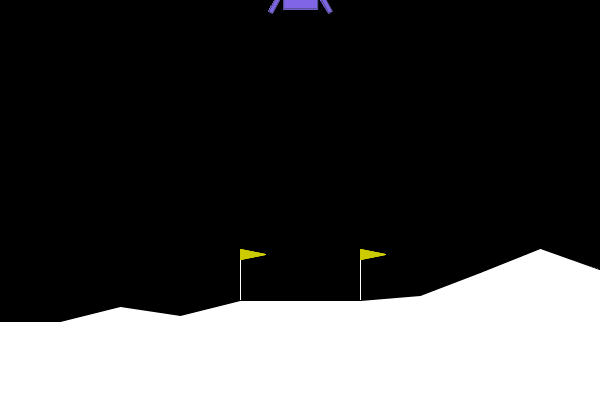

In [11]:
import glob
import io
import base64
import imageio
from IPython.display import HTML, display
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    done = False
    frames = []
    while not done:
        frame = env.render()
        frames.append(frame)
        action = agent.act(state)
        state, reward, done, _, _ = env.step(action.item())
    env.close()
    imageio.mimsave('video.gif', frames, fps=30)

show_video_of_model(agent, 'LunarLander-v2')

def show_video():
    giflist = glob.glob('*.gif')
    if len(giflist) > 0:
        gif = giflist[0]
        with open(gif, "rb") as f:
            encoded = base64.b64encode(f.read()).decode('ascii')
        display(HTML(data=f'<img src="data:image/gif;base64,{encoded}" />'))
    else:
        print("Could not find GIF")

show_video()
